<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# Model and Evaluation
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics


# statsmodel
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# spicy
from scipy.stats import skew
from scipy.stats import boxcox
from scipy.stats import yeojohnson

import warnings
warnings.filterwarnings('ignore')

In [2]:
from platform import python_version
print('Python version:', python_version())

Python version: 3.9.6


In [3]:
%reload_ext watermark
%watermark -a "Leandro Pessini" --iversions

Author: Leandro Pessini

sklearn    : 1.0.2
statsmodels: 0.13.2
sys        : 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:36:15) 
[Clang 11.1.0 ]
numpy      : 1.21.1
seaborn    : 0.11.1
matplotlib : 3.4.2
pandas     : 1.3.0



In [4]:
hourly_rentals = pd.read_csv('../data/processed/hourly_rentals.csv')
hourly_rentals.head()

,date,hour,rain,temp,rhum,wdsp,day,month,year,holiday,dayofweek_n,dayofweek,working_day,season,peak,timesofday,rainfall_intensity,wind_bft,temp_r,count
0,2021-03-01,2,0.0,-1.2,98,4,1,3,2021,False,0,Monday,True,Winter,False,Night,no rain,2,-1,1
1,2021-03-01,7,0.0,2.1,100,4,1,3,2021,False,0,Monday,True,Winter,True,Morning,no rain,2,2,3
2,2021-03-01,8,0.0,5.1,98,5,1,3,2021,False,0,Monday,True,Winter,True,Morning,no rain,2,5,1
3,2021-03-01,9,0.0,5.7,98,5,1,3,2021,False,0,Monday,True,Winter,True,Morning,no rain,2,6,4
4,2021-03-01,10,0.0,6.7,94,6,1,3,2021,False,0,Monday,True,Winter,True,Morning,no rain,2,7,4


(array([-12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,
          1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12]),
 array([0.62456611, 0.61033999, 0.60714807, 0.60669803, 0.61690717,
        0.62956234, 0.65335589, 0.67978715, 0.71103546, 0.74517983,
        0.78212442, 0.82425275, 1.        , 0.82425275, 0.78212442,
        0.74517983, 0.71103546, 0.67978715, 0.65335589, 0.62956234,
        0.61690717, 0.60669803, 0.60714807, 0.61033999, 0.62456611]),
 <matplotlib.lines.Line2D at 0x141daffa0>)

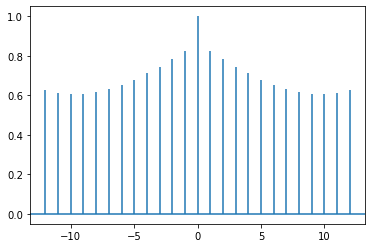

In [5]:
# Let's check autocorrelation of cnt values
plt.acorr(hourly_rentals["count"].astype(float), maxlags=12)

In [6]:
# since cnt is correlated with itself, let's lag the cnt column and consider it as a feature
t1 = hourly_rentals["count"].shift(+1).to_frame()
t1.columns = ["t-1"]
t2 = hourly_rentals["count"].shift(+2).to_frame()
t2.columns = ["t-2"]
t3 = hourly_rentals["count"].shift(+3).to_frame()
t3.columns = ["t-3"]
data_lag = pd.concat([hourly_rentals, t1, t2, t3], axis=1)
# drop the NaN values
data_lag.dropna(inplace=True)

In [8]:
data_lag.head()

,date,hour,rain,temp,rhum,wdsp,day,month,year,holiday,...,working_day,season,peak,timesofday,rainfall_intensity,wind_bft,count,t-1,t-2,t-3
3,2021-03-01,9,0.0,5.7,98,5,1,3,2021,False,...,True,Winter,True,Morning,no rain,2,4,1.0,3.0,1.0
4,2021-03-01,10,0.0,6.7,94,6,1,3,2021,False,...,True,Winter,True,Morning,no rain,2,4,4.0,1.0,3.0
5,2021-03-01,11,0.0,7.4,91,8,1,3,2021,False,...,True,Winter,False,Morning,no rain,3,4,4.0,4.0,1.0
6,2021-03-01,12,0.0,6.9,88,8,1,3,2021,False,...,True,Winter,False,Afternoon,no rain,3,8,4.0,4.0,4.0
7,2021-03-01,13,0.0,9.3,84,8,1,3,2021,False,...,True,Winter,False,Afternoon,no rain,3,11,8.0,4.0,4.0


In [15]:
df = hourly_rentals.copy()
df = df.astype({'holiday': 'category',
                'working_day': 'category',
                'peak': 'category',
                'timesofday': 'category',
                'rainfall_intensity': 'category',
                'wind_bft': 'category'})

df['humidity_norm'] = df['rhum']/100

# predictors = ['temp','wdsp','rhum','rain_type','holiday','season','peak','timesofday']
predictors = ['temp_r','wind_bft']

# hourly_data_temp['temp_type'] =  np.where(hourly_data_temp['temp'] > 10, 'High', 'Low')
df['prodTempWind'] = hourly_rentals['temp']*hourly_rentals['wdsp']
df['prodRainWind'] = hourly_rentals['rain']+hourly_rentals['wdsp']
# predictors = ['prodRainWind','prodTempWind','temp','rain_type']

# OrdinalEnconder was chosen due 
# enc = OrdinalEncoder(dtype=np.int64, categories=[['no rain', 'drizzle', 'light rain', 'moderate rain', 'heavy rain']])
# df['rain_type'] = enc.fit_transform(df[['rain_type']])

X = df[[c for c in df.columns if c in predictors]]
y = df.pop('count')

# X['rain_type'] = pd.to_numeric(X['rain_type'])

num_vars = [n for n in df.select_dtypes(include=['number']).columns if n in predictors] # list comprehension to select only predictors features
cat_vars = [c for c in df.select_dtypes(include=['category']).columns if c in predictors]

dummies = pd.get_dummies(X[cat_vars], drop_first=True)
X = pd.concat([X[num_vars], dummies],axis=1)
# y = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((4876, 8), (2090, 8))

In [16]:
X_train.head()

,temp_r,wind_bft_2,wind_bft_3,wind_bft_4,wind_bft_5,wind_bft_6,wind_bft_7,wind_bft_8
5768,7,0,0,1,0,0,0,0
2995,14,0,0,1,0,0,0,0
3820,17,1,0,0,0,0,0,0
2115,17,1,0,0,0,0,0,0
47,4,0,1,0,0,0,0,0


## OLS Assumptions

In [18]:
X_train = X_train['temp_r']
X_with_constant = sm.add_constant(X_train)
# model = smf.ols('count ~ temp + wdsp + rhum + rain_type + temp*wdsp +temp*rhum + peak + working_day + timesofday', data=X_with_constant).fit(cov_type='HC3')
# X_with_constant['prodTempWind'] = X_with_constant['temp']*X_with_constant['wdsp']
# X_with_constant['prodRainWind'] = X_with_constant['rain']+X_with_constant['wdsp']
# X_with_constant = X_with_constant[['const','temp']]
model = sm.OLS(y_train, X_with_constant).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     592.1
Date:                Wed, 27 Apr 2022   Prob (F-statistic):          1.58e-123
Time:                        13:19:42   Log-Likelihood:                -12681.
No. Observations:                4876   AIC:                         2.537e+04
Df Residuals:                    4874   BIC:                         2.538e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3982      0.098     24.460      0.0

In [13]:
X_test_with_constant = sm.add_constant(X_test)
y_pred = model.predict(X_test_with_constant)
residuals = y_test - y_pred
# predicted_values = model.predict()
ols_residuals = model.resid

### Assumption 1 - Linearity

This assumes that there is a linear relationship between the predictors and the response variable.

<!-- > "In statistics, a regression model is linear when all terms in the model are either the constant or a parameter multiplied by an independent variable." (Frost, 2020, p. 202)
Frost, J. (2020). Regression Analysis: An Intuitive Guide for Using and Interpreting Linear Models. Statistics By Jim Publishing. -->


In [14]:
#create instance of influence
influence = model.get_influence()
#obtain standardized residuals
standardized_residuals = influence.resid_studentized_internal
#display standardized residuals
print(standardized_residuals)

[-0.71287641  0.17384642  1.55061947 ...  0.81593668  0.78852521
 -0.80983635]


### Residuals x Temperature

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 6966 and the array at index 1 has size 4874

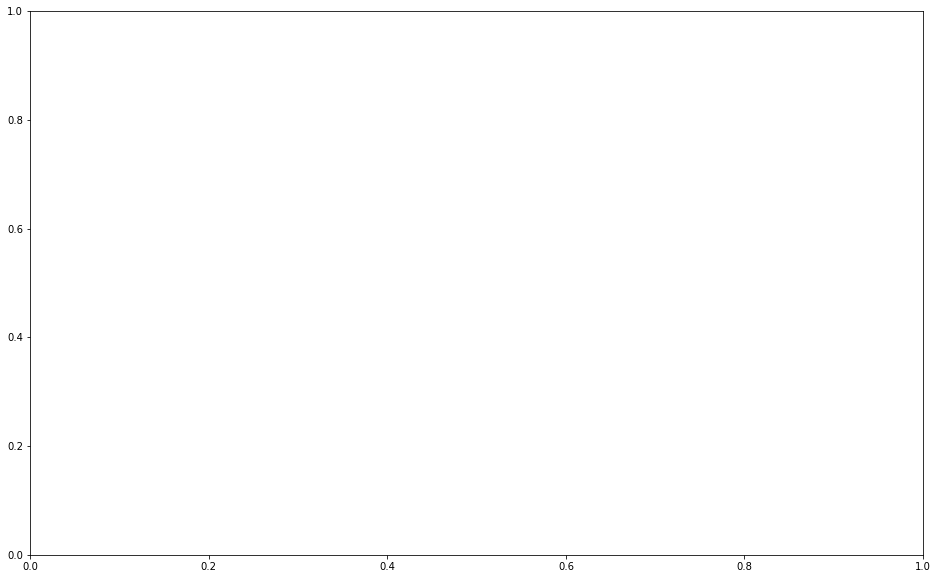

In [15]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.regplot(x=hourly_rentals['temp'], y=standardized_residuals, ax=ax, line_kws={'color': 'black', 'lw': 2, 'linestyle': '--'})
ax.set_title('Residuals vs. Temperature', fontsize=16)
ax.set(xlabel='Temperature', ylabel='Residuals')
plt.show()

### Residuals x Wind Speed

In [ ]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.regplot(x=X_train['wdsp'], y=standardized_residuals, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Wind Speed', fontsize=16)
ax.set(xlabel='Wind Speed', ylabel='Residuals')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.regplot(x=X_train['rhum'], y=standardized_residuals, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Wind Speed', fontsize=16)
ax.set(xlabel='Wind Speed', ylabel='Residuals')
plt.show()

In [ ]:
from sklearn.preprocessing import PowerTransformer
p = PowerTransformer(method = 'yeo-johnson')
y_train_tranformed = p.fit_transform(y_train.to_frame())

In [16]:
vif = [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns)

,vif
temp,1.231707
rhum,1.668582
wdsp,1.172234
t-1,1.513504
t-2,1.651419
t-3,1.509929
holiday_True,1.058226
working_day_True,1.372760
peak_True,1.480122
timesofday_Evening,1.516878


In [ ]:
fig = plt.figure(figsize=(16,12))
gs = fig.add_gridspec(2, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

sns.histplot(hourly_rentals['temp'],ax=ax0, stat='density', kde=True, 
             label= 'Skew :{0}'.format(np.round(skew(hourly_rentals['temp']),4)))
sns.histplot(hourly_rentals['rhum'],ax=ax1, stat='density', kde=True, 
             label= 'Skew :{0}'.format(np.round(skew(hourly_rentals['rhum']),4)))
sns.histplot(hourly_rentals['wdsp'],ax=ax2, stat='density', kde=True, 
             label= 'Skew :{0}'.format(np.round(skew(hourly_rentals['wdsp']),4)))
sns.histplot(hourly_rentals['count'],ax=ax3, stat='density', kde=True, 
             label= 'Skew :{0}'.format(np.round(skew(hourly_rentals['count']),4)))

ax0.set(xlabel='Temperature',title="Distribution - Temperature")
ax1.set(xlabel='Relative Humidity',title="Distribution - Relative Humidity")
ax2.set(xlabel='Wind Speed',title="Distribution - Wind Speed")
ax3.set(xlabel='Count', title="Distribution - Rentals Count")
ax0.legend(), ax1.legend(), ax2.legend(), ax3.legend()
plt.show()

In [ ]:
poly = PolynomialFeatures(degree = 3)
X_poly = poly.fit_transform(X_train)
X_poly_constant = sm.add_constant(X_poly)
lin2 = sm.OLS(y_train, X_poly_constant).fit()
linearity_test(lin2, y_train) 

In [ ]:
transformed_target, lam = boxcox(y_train)
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(y_train, label= 'Orginal Skew :{0}'.format(np.round(skew(y_train),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(transformed_target, label= 'Transformed Skew:{0}'.format(np.round(skew(transformed_target),4)), color='g', ax=ax[1], axlabel='BOX-COX TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()

In [ ]:
transformed_target, lam = yeojohnson(y_train)
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(y_train, label= 'Original Skew :{0}'.format(np.round(skew(y_train),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(transformed_target, label= 'Transformed Skew:{0}'.format(np.round(skew(transformed_target),4)), color='g', ax=ax[1], axlabel='BOX-COX TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()

In [ ]:
corrMatt = hourly_rentals[['temp','wdsp','rhum', 'rain','count']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
cmap = sns.diverging_palette(180, 20, as_cmap=True)

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corrMatt, mask=mask,vmax=.3, annot=True, ax=ax, cmap=cmap)
plt.show()

In [ ]:
hourly_data_temp = X_train.copy()
# hourly_data_temp['temp_type'] =  np.where(hourly_data_temp['temp'] > 10, 'High', 'Low')
# hourly_data_temp['prodTempWind'] = hourly_data_temp['temp']*hourly_data_temp['wdsp']
hourly_data_temp['prodRainWind'] = hourly_data_temp['rain']+hourly_data_temp['wdsp']

In [ ]:
hourly_data_temp.head(2)

In [ ]:
hourly_data_temp.drop(columns=['rain', 'wdsp'], inplace=True)
hourly_data_temp.head(2)

In [ ]:
X_with_constant = sm.add_constant(hourly_data_temp)
model = sm.OLS(y_train, X_with_constant).fit()
print(model.summary())

In [ ]:
linearity_test(model, y_train)

In [ ]:
X_with_constant.head()

In [ ]:
vif = [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=hourly_data_temp.columns).T

## Quantile Encoder

Encoder techinique to tackle high cardinality features.

In [ ]:
from collections import Counter
def cumulatively_categorise(column,threshold=0.75,return_categories_list=True):
  #Find the threshold value using the percentage and number of instances in the column
  threshold_value=int(threshold*len(column))
  #Initialise an empty list for our new minimised categories
  categories_list=[]
  #Initialise a variable to calculate the sum of frequencies
  s=0
  #Create a counter dictionary of the form unique_value: frequency
  counts=Counter(column)

  #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
  for i,j in counts.most_common():
    #Add the frequency to the global sum
    s+=dict(counts)[i]
    #Append the category name to the list
    categories_list.append(i)
    #Check if the global sum has reached the threshold value, if so break the loop
    if s>=threshold_value:
      break
  #Append the category Other to the list
  categories_list.append('Other')

  #Replace all instances not in our new categories by Other  
  new_column=column.apply(lambda x: x if x in categories_list else 'Other')

  #Return transformed column and unique values if return_categories=True
  if(return_categories_list):
    return new_column,categories_list
  #Return only the transformed column if return_categories=False
  else:
    return new_column


#Call the function with a default threshold of 75%
transformed_column,new_category_list=cumulatively_categorise(data['Qualification'],return_categories_list=True)

# Transformations

## Log Transformation

In [ ]:
log_target = np.log1p(hourly_rentals['count'])
# log_target = np.log1p(hourly_data['count'].sample(frac=0.2, replace=False))
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(hourly_rentals['count'], label= 'Orginal Skew:{0}'.format(np.round(skew(hourly_rentals['count']),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(log_target, label= 'Transformed Skew:{0}'.format(np.round(skew(log_target),4)), color='g', ax=ax[1], axlabel='LOG TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()

## Square Root Transformation

In [ ]:
sqrrt_target = hourly_rentals['count']**(1/2)
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(hourly_rentals['count'], label= 'Orginal Skew:{0}'.format(np.round(skew(hourly_rentals['count']),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(sqrrt_target, label= 'Transformed Skew:{0}'.format(np.round(skew(sqrrt_target),4)), color='g', ax=ax[1], axlabel='SQUARE ROOT TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()

## Reciprocal Transformation

In [ ]:
re_target = 1/hourly_rentals['count']
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(hourly_rentals['count'], label= 'Orginal Skew :{0}'.format(np.round(skew(hourly_rentals['count']),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(re_target, label= 'Transformed Skew:{0}'.format(np.round(skew(re_target),4)), color='g', ax=ax[1], axlabel='INVERSE TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()

## Box-cox Transformation

In [ ]:
bcx_target, lam = boxcox(hourly_rentals['count'])
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(hourly_rentals['count'], label= 'Orginal Skew :{0}'.format(np.round(skew(hourly_rentals['count']),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(bcx_target, label= 'Transformed Skew:{0}'.format(np.round(skew(bcx_target),4)), color='g', ax=ax[1], axlabel='BOX-COX TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()

## Yeo-Johnson Transformation

In [ ]:
yf_target, lam = yeojohnson(hourly_rentals['count'])
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(hourly_rentals['count'], label= 'Orginal Skew :{0}'.format(np.round(skew(hourly_rentals['count']),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(yf_target, label= 'Transformed Skew:{0}'.format(np.round(skew(yf_target),4)), color='g', ax=ax[1], axlabel='Y-J TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()